# Polarization week 1
`Dopo aver classificato, per la settimana di interesse, utenti influenti e non, si procede con il calcolo della polarizzazione`

In [1]:
import numpy as np
import itertools
import collections
import pandas as pd
from scipy.sparse import csr_matrix, coo_matrix

In [2]:
import sys
sys.path.append('../')

In [3]:
from lib import mongoAPI

## Read dataframe (da MongoDB)
Si ottengono tutte le interazioni (retweet) tra un utente influente (chiamato anche "Page") e un utente non influente ("User")

In [4]:
print("Connessione MongoDB...")
mongo_conn = mongoAPI.get_connection("localhost", 27027)
mongo_db = mongo_conn.get_db("dataman_project")
mongo_coll_links = mongo_db.get_collection("links")
print("Done")

Connessione MongoDB...
Done


In [5]:
week = 1
df = mongo_coll_links.read_df_week(week)
del df["week"]
df.head()

,page,user
0,2812961,2002721
1,2812961,2249785528
2,2812961,921682901212725248
3,2812961,808215598488489984
4,2812961,436239851


## Map users ID and pages ID to sequence (1,len(users))
Anziché gli ID utilizzati da Twitter, si associano, a pagine e utenti, un ID progressivo

In [6]:
mapping_pages = {user:index for index, user in enumerate(set(df["page"]))}
mapping_users = {page:index for index, page in enumerate(set(df["user"]))}
rev_dict_pages = {value:key for key,value in mapping_pages.items()}
rev_dict_users = {value:key for key,value in mapping_users.items()}

In [7]:
df_ = pd.DataFrame()
df_["page"] = df["page"].replace(mapping_pages)
df_["user"] = df["user"].replace(mapping_users)

## Visualizzazione grafo bipartito utenti - pagine

In [8]:
indexes = df_[["user", "page"]].to_numpy()
indexes

array([[ 8394,   949],
       [15346,   949],
       [    0,   949],
       ...,
       [13316,  1243],
       [30141,   912],
       [13316,  1243]])

## Costruzione matrice di proiezione (V,E)
#### V = Pagine
#### E = archi pesati con numeri di utenti condivisi tra le pagine

### 1- Creo dizionario:
* key = id utente
* value = lista pagine con cui ha interagito

In [9]:
user_pages_dict = collections.defaultdict(list)
for tuple_ in indexes:
    if tuple_[1] not in user_pages_dict[tuple_[0]]:
        user_pages_dict[tuple_[0]].append(tuple_[1])

#user_pages_dict

### 2- Lista di tuple:
Se un utente ha interagito con più di una pagina, allora tali pagine "condividono" quello stesso utente.

Genero tutte le permutazioni di 2 elementi estratti dalle pagine (la matrice di proiezione deve essere simmetrica).

In altri termini ogni volta che due pagine A e B condividono un utente genero tupla (A,B), che rappresenta un arco del grafo di proiezione

In [10]:
edges = [pages_index_pair for pages_index in user_pages_dict.values() if len(pages_index) > 1 for pages_index_pair in list(itertools.permutations(pages_index, 2))]
#edges

### 3- Pesi:
Contando le tuple ottengo il numero di utenti che la coppia (A,B) condivide, i.e. il peso dell'arco del grafo di proiezione

In [11]:
edges_weights = collections.Counter(edges)
#edges_weights

### 4- Matrice di proiezione:
Tenendo conto del volume, memorizzo la matrice in una matrice sparsa, cioè salvo solo gli archi effettivamente presenti, escludendo quelli con peso zero.
Ciò è possibile utilizzando matrici sparse di SciPy

In [12]:
def dict_to_sparse_matrix(dict_graph):
    data = np.array(list(dict_graph.values()))
    A = np.array(list(dict_graph.keys()))
    rows = A.T[1]
    cols = A.T[0]
    B = coo_matrix((data, (rows, cols)), shape=(len(mapping_pages), len(mapping_pages)))
    return csr_matrix(B)

In [13]:
P = dict_to_sparse_matrix(edges_weights)


## Community detection

### Si considerano due algoritmi di Community detection:
* Louvain Algorithm
* Label Propagation

In [14]:
from sknetwork.clustering import Louvain, PropagationClustering, modularity 

## Louvain

In [15]:
louvain = Louvain(modularity="dugue")
labels_louvain = louvain.fit_transform(P)

### Valutazione misura di modularità
Si valuta la bontà del clustering attraverso misura di modularità.
SPIEGAZIONE: range valori ecc..

In [16]:
modularity(P, labels_louvain, return_all=True)

(0.4051167761901391, 0.9157055571932613, 0.5105887810031222)

### Dimensione clusters

In [17]:
collections.Counter(labels_louvain)

Counter({1: 851,
         0: 1501,
         49: 1,
         3: 16,
         70: 1,
         2: 32,
         69: 1,
         68: 1,
         67: 1,
         66: 1,
         6: 3,
         65: 1,
         64: 1,
         63: 1,
         62: 1,
         71: 1,
         61: 1,
         59: 1,
         58: 1,
         9: 2,
         57: 1,
         56: 1,
         55: 1,
         54: 1,
         7: 3,
         53: 1,
         52: 1,
         51: 1,
         60: 1,
         73: 1,
         84: 1,
         74: 1,
         94: 1,
         93: 1,
         4: 4,
         92: 1,
         91: 1,
         90: 1,
         89: 1,
         88: 1,
         87: 1,
         86: 1,
         95: 1,
         85: 1,
         83: 1,
         82: 1,
         81: 1,
         5: 4,
         80: 1,
         79: 1,
         78: 1,
         77: 1,
         76: 1,
         75: 1,
         8: 2,
         50: 1,
         96: 1,
         44: 1,
         26: 1,
         25: 1,
         24: 1,
         23: 1,
         22

### Commento:
* Buon valore di modularità
* 2 grandi clusters

## Label Propagation

In [18]:
propagation = PropagationClustering(sort_clusters=True)
labels_propagation = propagation.fit_transform(P)

### Valutazione misura di modularità

In [19]:
modularity(P, labels_propagation, return_all=True)

(3.661894362760876e-05, 1.0, 0.9999633810563724)

### Dimensione clusters

In [20]:
collections.Counter(labels_propagation)

Counter({72: 2412,
         0: 1,
         1: 1,
         2: 1,
         3: 1,
         4: 1,
         5: 1,
         6: 3,
         7: 1,
         8: 1,
         9: 1,
         10: 1,
         11: 1,
         12: 1,
         13: 1,
         14: 1,
         15: 1,
         16: 1,
         17: 1,
         18: 1,
         19: 3,
         20: 1,
         21: 1,
         22: 1,
         23: 1,
         24: 1,
         25: 1,
         26: 1,
         27: 1,
         28: 1,
         29: 1,
         30: 1,
         31: 1,
         32: 1,
         33: 1,
         34: 1,
         35: 1,
         36: 1,
         37: 1,
         38: 1,
         39: 1,
         40: 1,
         41: 1,
         42: 1,
         43: 1,
         44: 1,
         45: 1,
         46: 1,
         47: 1,
         48: 1,
         49: 1,
         50: 1,
         51: 1,
         52: 1,
         53: 1,
         54: 1,
         55: 1,
         56: 1,
         57: 1,
         58: 1,
         59: 1,
         60: 1,
         61: 1,

### Commento:
* Modularità pessima
* 1 unico grande cluster

### Osservazioni:
* In questo caso Louvain produce risultati nettamente migliori

## Validazione manuale (quale cluster è vax e quale non)
Non avendo dati disponibili per una validazione supervisionata si procede manualmente:
Per ogni cluster si estrae un campione di utenti, e studiandone il feed, si decide se essi siano pro-vax, no-vax o neutrali

### Verifichiamo chi sono alcuni di loro con le API di Twitter

In [22]:
import tweepy
#Configurazione e autenticazione
access_token = "1328983562767519750-dF4HK59zfJrtqmnziHoM7eMHuQZN2F"  
access_token_secret = "NwYbWnA5rnxkxQISCuvxRk3wG5YVqwstp3w6Uz4uCp8H2"  
consumer_key = "y3TqPO1ZOOajzhX7Fh0tpc59M"  
consumer_secret = "ll4t1rp3rrHvsYtzONUhpKemaqFtVWWmEQKOODasdyJwajiUsx"  

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

_____________________________________________________________________________________________________________________________________

### Cluster 0

_____________________________________________________________________________________________________________________________________

In [23]:
print(rev_dict_pages[1], labels_louvain[1])

732817452569141248 0


In [24]:
print(api.get_user(732817452569141248).screen_name)

RobertoBurioni


NB. dalla presenza di Burioni nel cluster 0 si può intuire che si tratti di quello dei Pro vax

***

In [25]:
print(rev_dict_pages[811], labels_louvain[811])

86936133 0


In [62]:
print(api.get_user(86936133 ).screen_name)

ThManfredi


pro vax

_____________________________________________________________________________________________________________________________________

In [27]:
print(rev_dict_pages[20], labels_louvain[20])

131178507 0


In [63]:
print(api.get_user(131178507).screen_name)

marcocongiu


***

In [29]:
print(rev_dict_pages[947], labels_louvain[947])

106548241 0


In [64]:
print(api.get_user(106548241).screen_name)

MarioFurore


pro vax

_____________________________________________________________________________________________________________________________________

### Cluster 1

***


In [65]:
print(rev_dict_pages[0], labels_louvain[0])

1024702799215509504 1


In [66]:
print(api.get_user(1024702799215509504).screen_name)

EmpfindsamerS


no vax

***


In [69]:
print(rev_dict_pages[384], labels_louvain[384])

314537220 1


In [70]:
mapping_pages[314537220]

384

In [34]:
print(api.get_user(103519039).screen_name)

MarikaMori


no vax

_____________________________________________________________________

In [72]:
print(rev_dict_pages[272], labels_louvain[272])

721052101649002497 1


In [36]:
print( api.get_user(721052101649002497).screen_name)

Fra_tante3


no vax

______________________________________________

In [73]:
print(rev_dict_pages[762], labels_louvain[762])

1343531349706223618 1


In [74]:
print(api.get_user(1343531349706223618).screen_name)

DReqvenge2020


no vax

______________________________________________

## Osservazioni:
* 1 -> novax
* 0 -> provax

# Polarizzazione
## Distribuzione vax - novax
Si sceglie il clustering prodotto da Algoritmo Louvain

In [39]:
page_community_df = pd.DataFrame({"page_id" : rev_dict_pages.values(), "community" : labels_louvain})
page_community_df.head()

,page_id,community
0,1024702799215509504,1
1,732817452569141248,0
2,765979700808286208,1
3,1182665278917885955,0
4,932702612356464642,1


## Conservo solo le pagine dei due cluster principali

In [40]:
page_community_df = page_community_df[(page_community_df["community"] == 0) | (page_community_df["community"] == 1)]
page_community_df.head()

,page_id,community
0,1024702799215509504,1
1,732817452569141248,0
2,765979700808286208,1
3,1182665278917885955,0
4,932702612356464642,1


## Conto, per ciascun utente, numero di interazioni con ciascuna community

In [41]:
result = pd.merge(df, page_community_df, how="inner", left_on="page", right_on = "page_id")
result.head()

,page,user,page_id,community
0,2812961,2002721,2812961,0
1,2812961,2249785528,2812961,0
2,2812961,921682901212725248,2812961,0
3,2812961,808215598488489984,2812961,0
4,2812961,436239851,2812961,0


In [42]:
count_interact_community  = result.groupby(["user", "community"]).count().sort_values("page").reset_index()
count_interact_community

,user,community,page,page_id
0,1386297698337308676,0,1,1
1,1025115175798620162,0,1,1
2,1189450778,0,1,1
3,1025137091435548672,0,1,1
4,1189093086,0,1,1
...,...,...,...,...
31964,971816547898490881,1,176,176
31965,1322010178078859264,1,179,179
31966,4160203479,1,185,185
31967,742397759991480320,1,234,234


Si osserva che molti utenti interagiscono con entrambe le community, per cui la polarizzazione non è immediata:

In [43]:
tmp = count_interact_community.groupby("user").count().reset_index()
tmp[tmp["community"] >= 2][["user", "community"]]

,user,community
16,817997,2
70,8960282,2
81,9437162,2
97,10350822,2
123,12194852,2
...,...,...
29882,1367024121515827201,2
29887,1367131266060070912,2
29890,1367147372883701761,2
29922,1367773666155626499,2


In [44]:
del tmp

Ad es. l'utente seguente:

In [45]:
result[result["user"] == 8960282]

,page,user,page_id,community
32185,840370952,8960282,840370952,0
39274,1320662809248780288,8960282,1320662809248780288,0
40314,368588066,8960282,368588066,0
40632,429391019,8960282,429391019,0
42820,1169254465632972800,8960282,1169254465632972800,1
47618,3300404680,8960282,3300404680,0
52511,11170692,8960282,11170692,1
54741,104170025,8960282,104170025,1
56662,3096871079,8960282,3096871079,1
77867,2719470235,8960282,2719470235,0


In [46]:
count_interact_community_pivot = count_interact_community.pivot(index = "user", columns="community", values = "page")
count_interact_community_pivot.fillna(0, inplace = True)
count_interact_community_pivot

community,0,1
user,,
3637,2.0,0.0
382393,1.0,0.0
447813,2.0,0.0
507413,2.0,0.0
617033,2.0,0.0
...,...,...
1377601106969305088,0.0,1.0
1377977208929665026,2.0,0.0
1383442582768820235,0.0,1.0


## Si considerano solo utenti con almeno 10 interazioni

In [47]:
count_interact_community_pivot = count_interact_community_pivot[count_interact_community_pivot[0] + count_interact_community_pivot[1] > 10]
count_interact_community_pivot

community,0,1
user,,
2002721,15.0,0.0
6012422,0.0,11.0
8960282,7.0,7.0
10282412,24.0,0.0
14073125,35.0,0.0
...,...,...
1367147372883701761,1.0,14.0
1367203155440771082,0.0,15.0
1367413195279904768,11.0,0.0


# Costruzione della PDF

In [48]:
def polarization(pos, neg):
    return (pos-neg)/(pos+neg)

In [49]:
def polarization_neutral(pos,neg,neut):
    N = pos+neg+neut
    a = (pos-neg)/(pos+neg)
    return a - a*neut/N

In [50]:
data = polarization(count_interact_community_pivot[0], count_interact_community_pivot[1]).to_numpy()
data

array([ 1., -1.,  0., ...,  1., -1., -1.])

## Kernel Density Estimation

In [51]:
from scipy.stats.kde import gaussian_kde
from numpy import linspace
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

kde = gaussian_kde(data)
dist_space = linspace(min(data), max(data), 100)
x = kde(dist_space)
peaks, _ = find_peaks(x, distance=50)

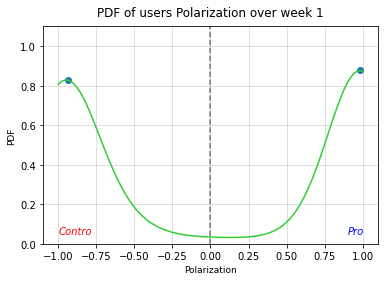

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(f"PDF of users Polarization over week {week}", pad = 10)
ax.grid(alpha = 0.5)
ax.axvline(0, color = "black", linestyle='--', alpha = 0.5)
ax.plot(dist_space[peaks], x[peaks], "o")
ax.plot(dist_space, x, color = "limegreen")
ax.set_xlabel('Polarization', fontsize=9)
ax.set_ylabel('PDF', fontsize=9)
ax.set_ylim(0,1.1)
ax.text(0.9, 0.05, 'Pro', style='italic', color = "b")
ax.text(-1, 0.05, 'Contro', style='italic', color = "r")
plt.show()

## Osservazioni:
* Distribuzione bimodale

(array([640., 140.,  55.,  37.,  14.,  21.,  13.,   7.,   3.,   1.,  14.,
          4.,   4.,   5.,   2.,  19.,   6.,  24.,  63., 785.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <BarContainer object of 20 artists>)

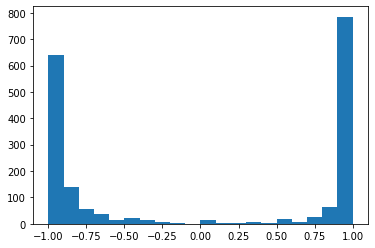

In [53]:
plt.hist(data, bins = 20)

## Osservazioni:
* Distribuzione bimodale

## Test statistico di bimodalità (Dip Test)
H_0 : Distribuzione unimodale

In [54]:
import unidip.dip as dip

data = np.msort(data)
test = dip.diptst(data)
print(test) #dip, pvalue, indices

(0.19978459881529348, 0.000999000999000999, (255, 255))


Si rifiuta ipotesi nulla di unimodalità con confidenza del 1 %

## Bimodality Coeff

In [55]:
from scipy.stats import kurtosis, skew
def bimodality_coeff(distr):
    g = skew(distr)
    k = kurtosis(distr)
    n = len(distr)
    return (g**2 + 1) / (k + 3*(n-1)**2/((n-2)*(n-3)))

In [56]:
bc = bimodality_coeff(data)
bc

0.9353400664234828

In [57]:
def bimodality_ratio(a,b):
    return a/b if a < b else b/a

In [58]:
bimodal_ratio = bimodality_ratio(*list(x[peaks]))
bimodal_ratio

0.9450385806170641

In [59]:
bc*bimodal_ratio

0.8839324487671186

In [60]:
import pickle

with open("polarization.pickle", "ab") as file:
    pickle.dump({"week" : week, "bimodality_coeff" : bc, "bimodality_ratio" : bimodal_ratio, "dip_stat" : test[0]}, file)